In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#importing necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from pathlib import Path
import h5py
import cv2

In [5]:
os.chdir("/content/drive/MyDrive/Brain Tumor Classification")

## Data Pre-Processing

In [6]:
p = Path("./dataset/")

In [7]:
cnt = 0
X = []
Y = []

for file_path in p.glob("*.mat"):
  f = h5py.File(file_path,'r')
  image = f.get('cjdata').get('image')
  label = f.get('cjdata').get('label')
  image = np.array(image)
  image = cv2.rotate(image,rotateCode=cv2.ROTATE_90_CLOCKWISE)
  image = cv2.resize(image,(150,150))
  label = np.array(label)
  X.append(image)
  Y.append(label)
  cnt += 1
        
print(f'Total files: {cnt}')

Total files: 3064


In [8]:
X = np.array(X)
Y = np.array(Y)

In [9]:
print(X.shape,Y.shape)

(3064, 150, 150) (3064, 1, 1)


In [10]:
Y = Y.reshape((-1,))

In [11]:
print(X.shape,Y.shape)

(3064, 150, 150) (3064,)


In [12]:
def shuffle_dataset(X, Y):
    rng_state = np.random.get_state()
    np.random.shuffle(X)
    np.random.set_state(rng_state)
    np.random.shuffle(Y)

In [13]:
shuffle_dataset(X,Y)

In [14]:
Y = Y-1

In [15]:
label_to_name = {0:'meningioma',1:'glioma',2:'pituitary'}

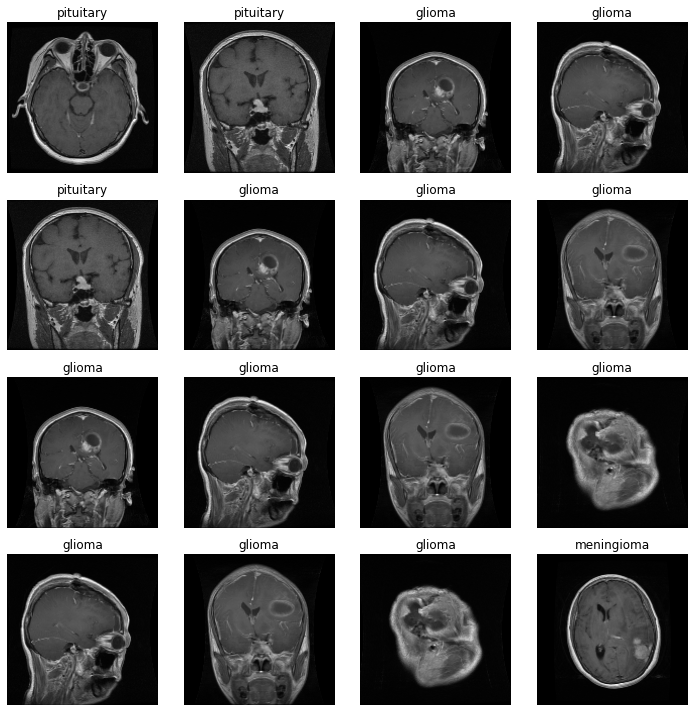

In [16]:
fig, axs = plt.subplots(4,4,figsize=(10,10))

for i in range(4):
  for j in range(4):
    axs[i][j].imshow(X[i+j],cmap='gray')
    axs[i][j].set_title(label_to_name[Y[i+j]])
    axs[i][j].axis('off')

fig.tight_layout()

In [17]:
n_train = int(cnt*0.8)

In [18]:
X_train = X[:n_train]
Y_train = Y[:n_train]
X_val = X[n_train:]
Y_val = Y[n_train:]

In [19]:
print(X_train.shape,Y_train.shape)

(2451, 150, 150) (2451,)


In [20]:
print(X_val.shape,Y_val.shape)

(613, 150, 150) (613,)


In [21]:
from keras.utils.np_utils import to_categorical 
Y_train = to_categorical(Y_train, num_classes = 3)
Y_val = to_categorical(Y_val, num_classes = 3)

In [22]:
print("X_train shape",X_train.shape)
print("X_val shape",X_val.shape)
print("Y_train shape",Y_train.shape)
print("Y_val shape",Y_val.shape)

X_train shape (2451, 150, 150)
X_val shape (613, 150, 150)
Y_train shape (2451, 3)
Y_val shape (613, 3)


## CNN Model

In [23]:
# importing necessary libraries for CNN 
import itertools
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [24]:
!pip install keras-tuner

     |████████████████████████████████| 133 kB 11.7 MB/s 


In [25]:
from keras_tuner.tuners import RandomSearch

In [26]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(150,150,1)))
    for i in range(hp.Int('num_layers', 2, 10)):
        model.add(Conv2D(filters=hp.Int('units_' + str(i),min_value=32,max_value=512),kernel_size=(5,5),padding='Same',activation='relu'))
        model.add(MaxPooling2D(hp.Choice('pool_size',[2,3,4,5]),padding='Same'))
        model.add(Dropout(hp.Choice('rate',[0.2,0.25,0.3,0.35,0.4])))
    model.add(Flatten())
    model.add(Dense(1024, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))
    model.compile(
        optimizer=Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics = ['accuracy'])
    return model

In [27]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=5,
    directory='project',
    project_name='Brain Tumor Classification')

In [28]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 1, 'sampling': None}
pool_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4, 5], 'ordered': True}
rate (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.25, 0.3, 0.35, 0.4], 'ordered': True}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [29]:
#increase epochs for more accurate results
tuner.search(X_train, Y_train,epochs=5,validation_data=(X_val, Y_val))

Trial 5 Complete [00h 14m 50s]
val_accuracy: 0.7768352389335632

Best val_accuracy So Far: 0.8238172888755798
Total elapsed time: 01h 02m 10s
INFO:tensorflow:Oracle triggered exit


In [30]:
tuner.results_summary()

Results summary
Results in project/Brain Tumor Classification
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 5
units_0: 269
pool_size: 2
rate: 0.2
units_1: 265
learning_rate: 0.001
units_2: 103
units_3: 32
units_4: 32
Score: 0.8238172888755798
Trial summary
Hyperparameters:
num_layers: 8
units_0: 347
pool_size: 3
rate: 0.4
units_1: 403
learning_rate: 0.001
units_2: 191
units_3: 188
units_4: 161
units_5: 32
units_6: 32
units_7: 32
Score: 0.7768352389335632
Trial summary
Hyperparameters:
num_layers: 3
units_0: 53
pool_size: 2
rate: 0.2
units_1: 364
learning_rate: 0.001
units_2: 32
Score: 0.7429037451744079
Trial summary
Hyperparameters:
num_layers: 2
units_0: 273
pool_size: 2
rate: 0.4
units_1: 54
learning_rate: 0.01
units_2: 67
Score: 0.5807504117488861
Trial summary
Hyperparameters:
num_layers: 3
units_0: 136
pool_size: 3
rate: 0.25
units_1: 161
learning_rate: 0.01
units_2: 200
Score: 0.5161500751972199


In [31]:
from keras.wrappers.scikit_learn import KerasClassifier

In [32]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 150, 150, 269)     6994      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 75, 75, 269)      0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 75, 75, 269)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 75, 75, 265)       1782390   
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 38, 38, 265)      0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 38, 38, 265)      

In [34]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics = ['accuracy'])

In [35]:
import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99 and logs.get('val_accuracy')>0.99):
      print("\n\nTrain and validation accuracy has reached the value > 99%!")
      self.model.stop_training = True
callbacks = myCallback()

In [36]:
epochs = 50  
batch_size = 32

import time

start = time.time()
history = model.fit(X_train,Y_train,batch_size,epochs=100, validation_data = (X_val,Y_val),steps_per_epoch = X_train.shape[0] // batch_size,callbacks=[callbacks])
stop = time.time()


Epoch 1/100
76/76 [==============================] - 39s 503ms/step - loss: 16.2477 - accuracy: 0.4268 - val_loss: 0.9299 - val_accuracy: 0.4910
Epoch 2/100
76/76 [==============================] - 37s 495ms/step - loss: 1.8456 - accuracy: 0.4659 - val_loss: 0.9112 - val_accuracy: 0.6623
Epoch 3/100
76/76 [==============================] - 37s 494ms/step - loss: 1.1563 - accuracy: 0.5151 - val_loss: 0.9436 - val_accuracy: 0.6672
Epoch 4/100
76/76 [==============================] - 38s 495ms/step - loss: 1.0269 - accuracy: 0.5515 - val_loss: 0.9368 - val_accuracy: 0.6542
Epoch 5/100
76/76 [==============================] - 37s 494ms/step - loss: 0.9519 - accuracy: 0.5912 - val_loss: 0.9044 - val_accuracy: 0.6737
Epoch 6/100
76/76 [==============================] - 37s 492ms/step - loss: 0.9013 - accuracy: 0.6193 - val_loss: 0.8964 - val_accuracy: 0.6705
Epoch 7/100
76/76 [==============================] - 37s 493ms/step - loss: 0.8766 - accuracy: 0.6251 - val_loss: 0.8598 - val_accuracy

## Saving Trained CNN Model for Future Use

In [37]:
model.save('CNNTunedModel.h5')
print("Save successfully CNNTunedModel.h5")

Save successfully CNNTunedModel.h5


In [38]:
from tensorflow.keras.models import load_model
from keras.models import Model

In [39]:
model = load_model('CNNTunedModel.h5')

In [40]:
model_new = Model(model.input,model.layers[-2].output)

Plotting Graphs

In [41]:
plt.style.use('seaborn')

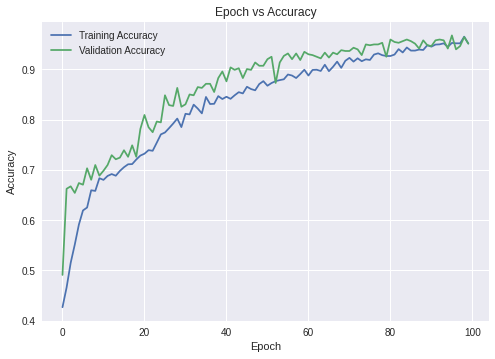

In [42]:
plt.plot(history.history['accuracy'],label='Training Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Epoch vs Accuracy')
plt.legend()
plt.show()

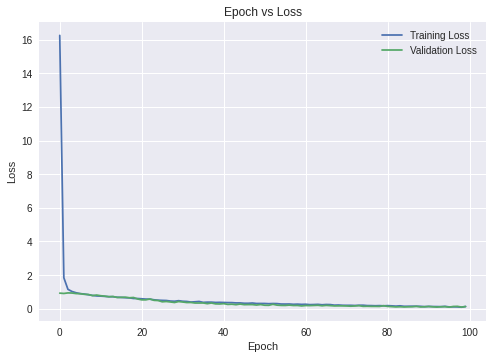

In [43]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch vs Loss')
plt.legend()
plt.show()

CNN Classification Report

In [241]:
Y_pred = model.predict(X_val)

In [242]:
from sklearn.metrics import classification_report

In [243]:
categories = ["meningioma_tumor","glioma_tumor","pituitary_tumor"]

In [244]:
Y_pred = np.argmax(Y_pred,axis=1)

In [245]:
print("CNN Classification Report\n")
print(classification_report(Y_val, Y_pred,target_names = categories))

CNN Classification Report

                  precision    recall  f1-score   support

meningioma_tumor       0.90      0.90      0.90       147
    glioma_tumor       0.97      0.95      0.96       280
 pituitary_tumor       0.97      0.99      0.98       186

        accuracy                           0.95       613
       macro avg       0.94      0.95      0.95       613
    weighted avg       0.95      0.95      0.95       613



In [246]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

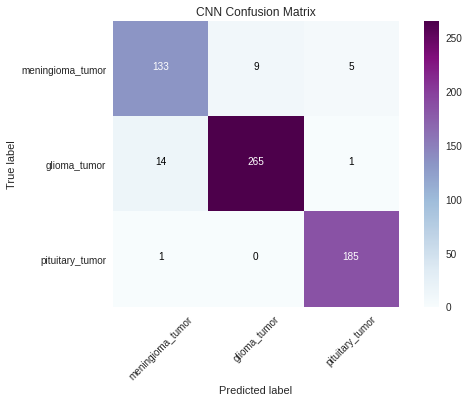

In [247]:
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(Y_val, Y_pred) 
plt.grid(False)
plt.style.use('seaborn')
plot_confusion_matrix(confusion_mtx, title='CNN Confusion Matrix',classes = categories)

In [248]:
print(f"CNN Validation Accuracy: {np.sum((Y_pred==Y_val))/(Y_val.shape[0])*100}%")

CNN Validation Accuracy: 95.10603588907016%


Improving Accuracy using Random Forest

In [249]:
from sklearn.ensemble import RandomForestClassifier

In [250]:
X_train_out = model_new.predict(X_train)

In [251]:
X_val_out = model_new.predict(X_val)

In [252]:
print(Y_train.shape,Y_val.shape)

(2451,) (613,)


In [253]:
from sklearn.model_selection import GridSearchCV 

In [254]:
parameter_grid = {'max_depth':np.arange(2,51),
                  'criterion':['entropy','gini']
                 }

In [255]:
rf = RandomForestClassifier(n_estimators=100,criterion='entropy')

In [256]:
mygrid = GridSearchCV(estimator=rf, param_grid=parameter_grid, n_jobs=1, cv=2)
grid_result = mygrid.fit(X_train_out,Y_train)

In [200]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.987353 using {'criterion': 'entropy', 'max_depth': 21}


In [257]:
rf = RandomForestClassifier(criterion='entropy',max_depth=21)

In [258]:
parameter_grid = {'n_estimators':np.arange(3,101)}
mygrid = GridSearchCV(estimator=rf, param_grid=parameter_grid, n_jobs=1, cv=2)
grid_result = mygrid.fit(X_train_out,Y_train)

In [259]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.988169 using {'n_estimators': 64}


In [260]:
rf = RandomForestClassifier(criterion='entropy',max_depth=21,n_estimators=64)

In [261]:
rf.fit(X_train_out,Y_train)

RandomForestClassifier(criterion='entropy', max_depth=21, n_estimators=64)

In [262]:
Y_pred = rf.predict(X_val_out)

Random Forest Classification Report

In [263]:
from sklearn.metrics import classification_report

In [264]:
print("CNN-RF Classification Report\n")
categories = ["meningioma_tumor","glioma_tumor","pituitary_tumor"]
print(classification_report(Y_val, Y_pred,target_names = categories))

CNN-RF Classification Report

                  precision    recall  f1-score   support

meningioma_tumor       0.92      0.90      0.91       147
    glioma_tumor       0.96      0.96      0.96       280
 pituitary_tumor       0.99      0.99      0.99       186

        accuracy                           0.96       613
       macro avg       0.96      0.95      0.96       613
    weighted avg       0.96      0.96      0.96       613



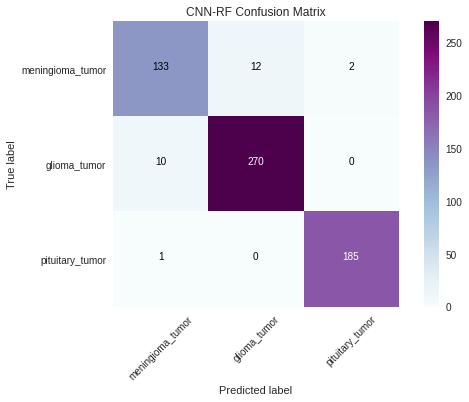

In [265]:
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(Y_val, Y_pred) 
plt.grid(False)
plot_confusion_matrix(confusion_mtx, title="CNN-RF Confusion Matrix",classes = categories)

In [266]:
print(f"CNN-RF Validation Accuracy: {np.sum((Y_pred==Y_val))/(Y_val.shape[0])*100}%")

CNN-RF Validation Accuracy: 95.92169657422512%


Imporving Accuracy using SVM

In [267]:
from libsvm.svmutil import *

In [268]:
m = svm_train(Y_train,X_train_out)

In [269]:
X_val_out = model_new.predict(X_val)

In [270]:
print("Training Accuracy")
p_label, p_acc, p_val = svm_predict(Y_train, X_train_out, m)

Training Accuracy
Accuracy = 98.4088% (2412/2451) (classification)


In [271]:
print("Validation Accuracy")
p_label, p_acc, p_val = svm_predict(Y_val, X_val_out, m)

Validation Accuracy
Accuracy = 96.0848% (589/613) (classification)


SVM Classification Report

In [272]:
print("CNN-SVM Classification Report\n")
categories = ["meningioma_tumor","glioma_tumor","pituitary_tumor"]
print(classification_report(Y_val,p_label,target_names = categories))

CNN-SVM Classification Report

                  precision    recall  f1-score   support

meningioma_tumor       0.92      0.92      0.92       147
    glioma_tumor       0.96      0.96      0.96       280
 pituitary_tumor       0.99      0.99      0.99       186

        accuracy                           0.96       613
       macro avg       0.96      0.96      0.96       613
    weighted avg       0.96      0.96      0.96       613



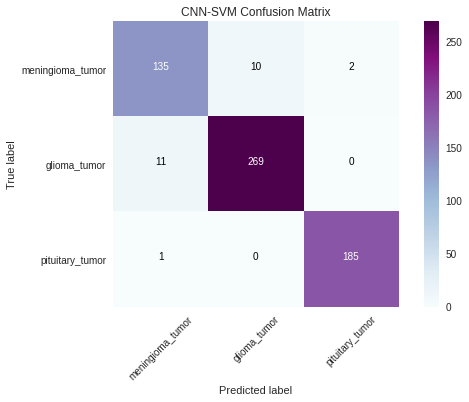

In [273]:
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(Y_val, p_label) 
plt.grid(False)
plot_confusion_matrix(confusion_mtx, title="CNN-SVM Confusion Matrix",classes = categories)

In [274]:
p_label = np.array(p_label)

In [276]:
print(f"CNN-SVM Validation Accuracy: {np.sum((Y_pred==p_label))/(p_label.shape[0])*100}%")

CNN-SVM Validation Accuracy: 98.85807504078304%
